## Food-Vision 

1. Problem
2. Data
3. Evaluation

## 1. Problem
The project is aimed on creating a full-stock functioning model on the full data from the previous project that was based only on three subsets of the entire dataset

## 2. Data
Dataset was downloaded from 101-Food dataset website

## 3. Evaluation
Evaluation metric is going to be accuracy

In [5]:
import torch as pt
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from torch import nn
from torchinfo import summary
from pathlib import Path

In [3]:
from going_modular import data_setup, engine

## Importing data

In [9]:
data_path = Path('data/')
image_path = data_path / 'archive/food-101/food-101'

if image_path.is_dir():
    print(f'[INFO] {image_path} exists!')

[INFO] data\archive\food-101\food-101 exists!


## Creating Train and Test datasets

In [8]:
import os
import shutil
import json

In [21]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

os.makedirs(train_dir, exist_ok =True)
os.makedirs(test_dir, exist_ok=True)

# Read the json or txt files to get the mappings
with open(image_path / 'meta/train.json', 'r') as f:
    train_data = json.load(f)

with open(image_path / 'meta/test.json', 'r') as f:
    test_data = json.load(f)

def distribute_images(data, source_dir, target_dir):
    for category, images in data.items():
        # Create category sub-directory in target_dir
        category_dir = os.path.join(target_dir, category)
        os.makedirs(category_dir, exist_ok=True)

        for image in images:
            # The image path from the JSON file includes the category name but not the "images" subdirectory
            # Add the missing 'images' part to the source path
            src_path = os.path.join(source_dir, 'images', image + '.jpg')  # Assuming the file extension is '.jpg'

            # Construct the destination path by combining the category directory and image file name
            dst_path = os.path.join(category_dir, os.path.basename(image) + '.jpg')

            # Copy the image to the new directory if it exists
            if os.path.exists(src_path):
                shutil.copy(src_path, dst_path)
            else:
                print(f"File not found: {src_path}")

In [22]:
# Distribute the train and test images
distribute_images(train_data, image_path, train_dir)
distribute_images(test_data, image_path, test_dir)

## Create Datasets and Dataloaders

In [23]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [24]:
# Get the transforms used to create our pretrianed weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [25]:
# Create dataloader using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x268c2530340>,
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheese_plate',
  'cheesecake',
  'chicken_curry',
  'chicken_quesadilla',
  'chicken_wings',
  'chocolate_cake',
  'chocolate_mousse',
  'churros',
  'clam_chowder',
  'club_sandwich',
  'crab_cakes',
  'creme_brulee',
  'croque_madame',
  'cup_cakes',
  'deviled_eggs',
  'donuts',
  'dumplings',
  'edamame',
  'eggs_benedict',
  'escargots',
  'falafel',
  'filet_mignon',
  'fish_and_chips',
  'foie_gras',
  'french_fries',
  'french_onion_soup',
  'french_toast',
  'fried_calamari',
  'fried_rice',
  'frozen_yogurt',
  'garlic_bread',
  'gnocchi',
  'greek_salad',
  'grilled_cheese_sandwich',
  'grilled_salmon',
  'guacamole',
  'gyoza',
  'hamburger',
  'hot

In [28]:
len(class_names)

101

## Getting a pretrained model

In [29]:
model = torchvision.models.efficientnet_b0(weights=weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [30]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### Given pretrained model was trained on more than 1000 instances of data while our dataset consists only of 101 classes. We should make some adjustments in code

## Get a summary of our model with `torchinfo.summary()`

In [31]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

## Freezing the base model and changing the output layer to suit our needs

In [32]:
summary(model=model,
        input_size=(1,3,224,224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [33]:
# Freeze all the base layers in EffNetB0
for param in model.features.parameters():
    param.requires_grad = False

In [34]:
# Update the classifier head of our model to suit our problem
pt.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names))
)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=101, bias=True)
)

In [35]:
summary(model=model,
        input_size=(1,3,224,224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## Training a model

In [37]:
# define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = pt.optim.Adam(model.parameters(), lr=0.005)

In [38]:
# Set the manual seeds
pt.manual_seed(42)

# Set the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device='cpu')

# End the timer and print out how long it took
end_time = timer()
print(f'[INFO] Total training time: {end_time - start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8103 | train_acc: 0.3929 | test_loss: 2.0812 | test_acc: 0.5214
Epoch: 2 | train_loss: 2.6974 | train_acc: 0.4418 | test_loss: 2.1405 | test_acc: 0.5337
Epoch: 3 | train_loss: 2.7307 | train_acc: 0.4498 | test_loss: 2.1601 | test_acc: 0.5391
Epoch: 4 | train_loss: 2.7595 | train_acc: 0.4549 | test_loss: 2.2442 | test_acc: 0.5303
Epoch: 5 | train_loss: 2.7755 | train_acc: 0.4573 | test_loss: 2.1989 | test_acc: 0.5443
[INFO] Total training time: 28514.256 seconds


In [40]:
from helper_functions import plot_loss_curves

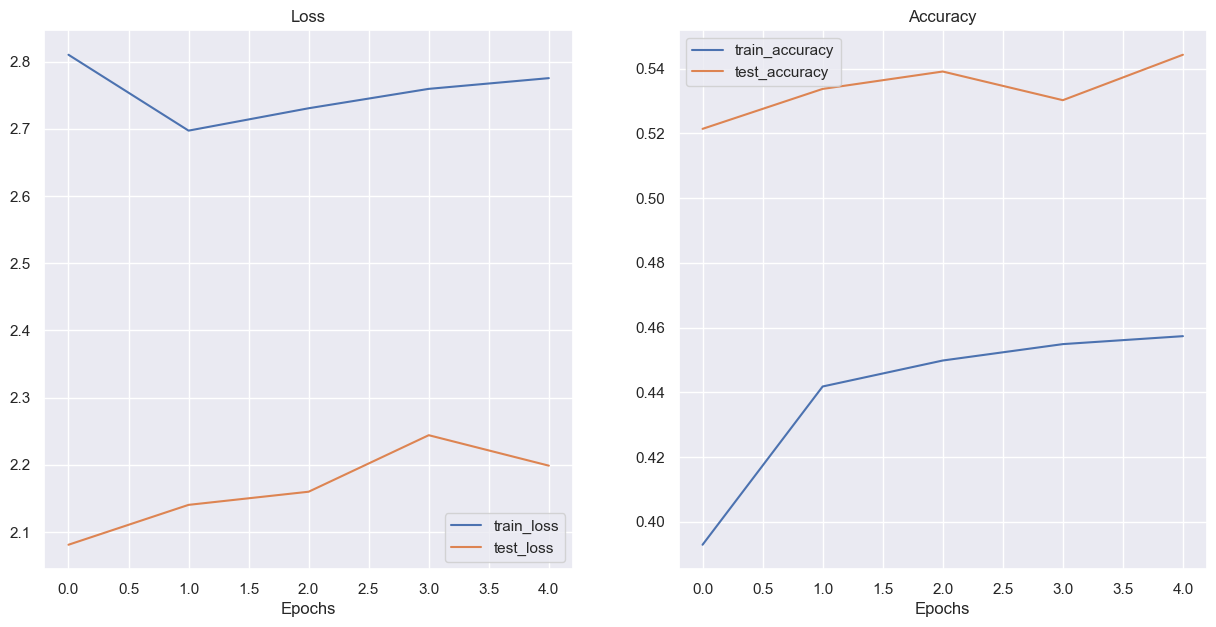

In [41]:
plot_loss_curves(results)

In [44]:
from typing import List, Tuple

from PIL import Image
from PIL import ImageOps

def pred_and_plot_image(model: pt.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224,224),
                        transform: torchvision.transforms = None):

    img = Image.open(image_path)
    img = ImageOps.exif_transpose(img)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])
        ])

    # Predict image
    model.eval()
    with pt.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)

        target_image_pred = model(transformed_image)

    target_image_pred_probs = pt.softmax(target_image_pred, dim=1)

    target_image_pred_label = pt.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.axis(False)
    plt.imshow(img)
    plt.title(f'Pred {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}')

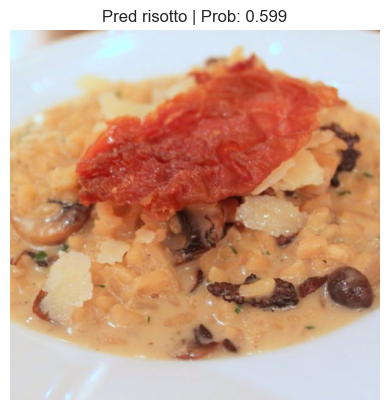

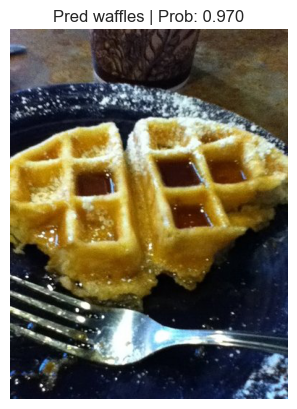

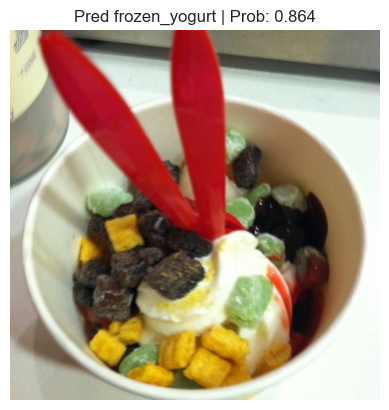

In [45]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224,224))